Demonstration of dynamic Gaussian Process Item Response Theory
with spactial-temporal relation.

In [1]:
# LOAD PACKAGES
import numpy as np
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
from binomial_likelihood import BinomialLikelihood
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
import torch
import gpytorch

background characteristics: x_i ~ N(0,1), i=1,2,3,4

normalized geospatial locations: g_1 ~ Unif(0,1), g_2 ~ Unif(0,1)

geospatial correlated noise: g_effect ~ N(0, K), K_{ij} = exp(-(g_i-g_j)^2/2)

temporal correlated noise: t_effect ~ N(0,K), K_t = exp(-(t-t')^2/2) 

temporal normalized latent policy positions: sigma_i = x_1^2 + x_2 + x_1*x_2 + cos(x3) - x_4^3 + t_effect * g_effect(i)

response model: y ~ binom(sigma_i,m), y=1,...,m

In [8]:
n = 100; # num of respondents
T = 10; # num of time periods
m = 10; # num of items in the battery
np.random.seed(12345)
x = np.zeros((n*T,4+2+1))
y = np.zeros((n*T,))

# background characteristics: x_i 
for i in range(4):
    x[:,i] = np.repeat(np.random.normal(loc=0.0, scale=1.0, size=(n,)),T)

# normalized geospatial locations: g_1 ~ Unif(0,1), g_2 ~ Unif(0,1)
g = np.random.uniform(low=0.0, high=1.0, size=(n,2))
x[:,4] = np.repeat(g[:,0],T)
x[:,5] = np.repeat(g[:,1],T)

# geospatial correlated noise: sigma(t) ~ N(0, K), K_{ij} = exp(-(g_i-g_j)^2/2), K_t = exp(-(t-t')^2/2) 
kernel = RBF(length_scale = 1.0)
# K = np.kron(kernel(g*2),kernel(np.arange(T).reshape(-1,1)/T*3))
K = kernel(g*2)
x[:,6] = np.tile(np.arange(T),n)
g_effects = np.random.multivariate_normal(np.zeros((n,)), K)

K = kernel(np.arange(T).reshape(-1,1)/T*3)
t_effects = np.random.multivariate_normal(np.zeros((T,)), K)

# normalized latent policy positions: 
f = x[:,0]**2 + x[:,1] + x[:,0]*x[:,1] + np.cos(x[:,2]) - x[:,3]**3
for t in range(T):
    f[x[:,6]==t] = t_effects[t]*g_effects
f_min = np.min(f)
f_max = np.max(f)
f = (f-f_min) / (f_max - f_min)

# response model: y ~ binom(sigma_i,m), y=1,...,m
for i in range(n*T):
    y[i] = np.random.binomial(m,f[i])

train_x = torch.from_numpy(x).double()
train_y = torch.from_numpy(y).double()

customize binomial likelihood model

In [9]:
from gpytorch.distributions import base_distributions
from gpytorch.functions import log_normal_cdf
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood

class BinomialLikelihood(_OneDimensionalLikelihood):
    r"""
    Implements the Binomial likelihood for count data y between 1 and m. 
    The Binomial distribution is parameterized by :math:`m > 0`. 
    We can write the likelihood as:

    .. math::
        \begin{equation*}
            p(Y=y|f,m)=\phi(f)^y(1-\phi(f))^{(m-y)}
        \end{equation*}
    """

    def __init__(self,m):
        super().__init__()
        if m<0 or int(m)!=m:
            self.m = 10
            print("m must be a positive integer!")
        else:
            self.m = m

    def forward(self, function_samples, **kwargs):
        output_probs = base_distributions.Normal(0, 1).cdf(function_samples)
        return base_distributions.Binomial(total_count=self.m, probs=output_probs)

    def log_marginal(self, observations, function_dist, *args, **kwargs):
        marginal = self.marginal(function_dist, *args, **kwargs)
        return marginal.log_prob(observations)

    def marginal(self, function_dist, **kwargs):
        mean = function_dist.mean
        var = function_dist.variance
        link = mean.div(torch.sqrt(1 + var))
        output_probs = base_distributions.Normal(0, 1).cdf(link)
        return base_distributions.Binomial(total_count=self.m, probs=output_probs)

    def expected_log_prob(self, observations, function_dist, *params, **kwargs):
        if torch.any(torch.logical_or(observations.le(-1), observations.ge(self.m+1))):
            # Remove after 1.0
            warnings.warn(
                "BinomialLikelihood.expected_log_prob expects observations with labels in [0, m]. "
                "Observations <0 or >m are not allowed.",
                DeprecationWarning,
            )
        else:
            observations = torch.clamp(observations,0,self.m)
        # Custom function here so we can use log_normal_cdf rather than Normal.cdf
        # This is going to be less prone to overflow errors
        log_prob_lambda = lambda function_samples: self.m*log_normal_cdf(-function_samples) + \
                observations.mul(log_normal_cdf(function_samples)-log_normal_cdf(-function_samples))
        log_prob = self.quadrature(log_prob_lambda, function_dist)
        return log_prob

customize gp model

In [10]:
class BinomialGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(BinomialGPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.LinearMean(input_size=train_x.size(1))
        # separate kernels for covariate, geospatial and time confounding
        self.x_covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(active_dims=[0,1,2,3], ard_num_dims=4))
        # use a product kernel for geospatial and time confounding
        # but in general can be replaced by a joint g and t kernel
        self.gt_covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(active_dims=[4,5], ard_num_dims=2)*\
                gpytorch.kernels.RBFKernel(active_dims=[6]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        # sum over all covariances
        covar_x = self.x_covar_module(x)
        covar_gt = self.gt_covar_module(x)
        covar = covar_x + covar_gt
        return gpytorch.distributions.MultivariateNormal(mean_x, covar)


optimize model parameters (variational locations and hyperparameters)

In [11]:
# initialize likelihood and model
likelihood = BinomialLikelihood(m=m)
model = BinomialGPModel(train_x=train_x).double()

training_iterations = 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

/Users/yahoo/anaconda3/lib/python3.7/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Iter 1/100 - Loss: 38.115
Iter 2/100 - Loss: 44.301
Iter 3/100 - Loss: 21.162
Iter 4/100 - Loss: 21.230
Iter 5/100 - Loss: 24.385
Iter 6/100 - Loss: 21.322
Iter 7/100 - Loss: 16.290
Iter 8/100 - Loss: 12.843
Iter 9/100 - Loss: 11.410
Iter 10/100 - Loss: 10.916
Iter 11/100 - Loss: 10.517
Iter 12/100 - Loss: 10.034
Iter 13/100 - Loss: 9.587
Iter 14/100 - Loss: 9.255
Iter 15/100 - Loss: 9.001
Iter 16/100 - Loss: 8.731
Iter 17/100 - Loss: 8.401
Iter 18/100 - Loss: 8.067
Iter 19/100 - Loss: 7.838
Iter 20/100 - Loss: 7.778
Iter 21/100 - Loss: 7.840
Iter 22/100 - Loss: 7.902
Iter 23/100 - Loss: 7.858
Iter 24/100 - Loss: 7.687
Iter 25/100 - Loss: 7.446
Iter 26/100 - Loss: 7.224
Iter 27/100 - Loss: 7.078
Iter 28/100 - Loss: 7.010
Iter 29/100 - Loss: 6.979
Iter 30/100 - Loss: 6.934
Iter 31/100 - Loss: 6.847
Iter 32/100 - Loss: 6.729
Iter 33/100 - Loss: 6.613
Iter 34/100 - Loss: 6.533
Iter 35/100 - Loss: 6.501
Iter 36/100 - Loss: 6.504
Iter 37/100 - Loss: 6.513
Iter 38/100 - Loss: 6.504
Iter 39/1

visualize estimated expected response for the first respondent

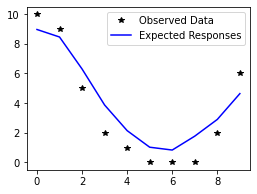

In [12]:
model.eval()
likelihood.eval()

with torch.no_grad():
    # plot the estimated latent f for first respondent
    test_x = train_x[0:T,:]
    # Get classification predictions
    observed_pred = likelihood(model(test_x))

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(test_x[:,6].numpy(), train_y[0:T].numpy(), 'k*')
    # Get the predicted labels
    pred_labels = observed_pred.mean.float()
    ax.plot(test_x[0:T,6].numpy(), pred_labels.numpy(), 'b')
    ax.legend(['Observed Data', 'Expected Responses'])

visualize estimated expected response for a virtual respondent with x_1=x_2=x_3=x_4=0 with the same geo locations as the first respondent

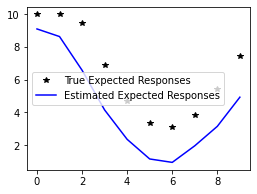

In [14]:
with torch.no_grad():
    # plot the estimated latent f for first respondent
    test_x = train_x[0:T,:]
    test_x[:,0:4] = 0
    # Get classification predictions
    observed_pred = likelihood(model(test_x))

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    true_f = 1 + t_effects * g_effects[0]
    true_f = (true_f - f_min) / (f_max - f_min)
    true_f = torch.clamp(torch.tensor(true_f), 0, 1)
    ax.plot(test_x[:,6].numpy(), true_f.numpy()*m, 'k*')
    # Get the predicted labels
    pred_labels = observed_pred.mean.float()
    ax.plot(test_x[0:T,6].numpy(), pred_labels.numpy(), 'b')
    ax.legend(['True Expected Responses', 'Estimated Expected Responses'])